In [1]:
import pandas as pd
import numpy as np
import csv
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import powerlaw,math
import os
import scipy.stats as stats
import random
from numpy import polyfit, poly1d

In [412]:
files = os.listdir('physics pubs')

In [413]:
TP = {}
for k in files:
    try:
        with open('physics pubs/'+k,'rb')as f:
            tp = pickle.load(f)
        for i in tp:
            TP[i] = tp[i]
    except:
        print(k)

In [414]:
pub_chemistry0 = TP
print(len(pub_chemistry0))

22500


In [415]:
#将生涯长度为0的做调整 (career length==0)
pub_chemistry = {}
empty=[]
nopa = []
for k in pub_chemistry0:
    tp = pub_chemistry0[k]
    if len(tp)>0:
        cl = tp[2]
        if cl==1:
            empty.append(k)
            tp[3] = tp[0]  # 0总发文量 total pubs
            tp[6] = tp[5]  # 5总引用 total citations
            tp[9] = tp[8]  # 8总合作者数 total coauthors
        else:
            tp = tp
    else:
        nopa.append(k)
        tp = tp
    pub_chemistry[k] = tp

In [416]:
neuro = pd.read_csv('physics_0123.csv')
# neuro = neuro[(neuro.StopYear<=1995)&(neuro.StopYear>=1960)]

In [417]:
Neuro = pd.read_csv('physics.csv')
MTO = np.array(Neuro.MentorID)

In [418]:
neuro.shape

(13837, 13)

In [419]:
neuro.head(1)

,Unnamed: 0,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,NumOfMenteesOfTheMentor,NumOfMenteesOfTheMentor10,NumOfMenteesOfTheMenteeIn20,BigOrSmall
0,3,6,18761,9,1,"University of California, Berkeley",95457486.0,-1,1984,8,4,0,1


In [422]:
StopYear = neuro.StopYear
print(min(StopYear))
print(max(StopYear))

1901
1995


2.0


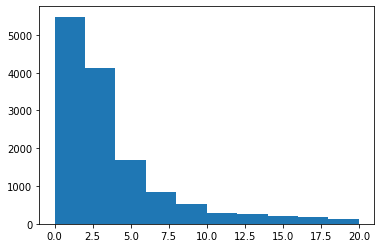

In [423]:
# tp = neuro.NumOfMenteesOfTheMentor
tp = neuro.NumOfMenteesOfTheMentor10
plt.hist(tp,range=[0,20],bins=10)
print(np.median(tp))

In [424]:
mentee = neuro.MenteeID; mentee_np = np.array(mentee)
mentor = neuro.MentorID; mentor_np = np.array(mentor)
StopYear = neuro.StopYear; StopYear_np = np.array(StopYear)

In [427]:
neuro.shape

(13837, 13)

In [428]:
# 在进行退出率的相关计算时，以所有的学生数为参考 (survival rate)
TP = []
for k in neuro.MenteeID:
    if k in MTO:
        TP.append(1)
    else:
        TP.append(0)
neuro['Survival0'] = TP              
# neuro = neuro[neuro.StopYear<2000]

In [429]:
#测试大小团队中的生存率 (test survial rate)
all_big = neuro['MenteeID'][neuro.BigOrSmall==1]
all_small = neuro['MenteeID'][neuro.BigOrSmall==0]
sb = neuro['MenteeID'][neuro.Survival0==1]
sur_big = all_big[all_big.isin(sb)]
sur_small = all_small[all_small.isin(sb)]
print(len(sur_big)/len(all_big))
print(len(sur_small)/len(all_small))

0.5030355594102341
0.7072667217175888


In [432]:
#在进行学生表现的相关计算时，以前20年是否招到学生作为活下的参照 (fecundity)
TP = []
for k in neuro.NumOfMenteesOfTheMenteeIn20:
    if k>0:
        TP.append(1)
    else:
        TP.append(0)
neuro['Survival1'] = TP              

In [433]:
#测试大小团队中的生存率 (test survival)
all_big = neuro['MenteeID'][neuro.BigOrSmall==1]
all_small = neuro['MenteeID'][neuro.BigOrSmall==0]
sb = neuro['MenteeID'][neuro.Survival1==1]
sur_big = all_big[all_big.isin(sb)]
sur_small = all_small[all_small.isin(sb)]

In [434]:
len(sb)

7199

In [435]:
print(len(sur_big)/len(all_big))
print(len(sur_small)/len(all_small))

0.4203527030933796
0.565028901734104


##### 只选择1995年之前的学生 (mentees before 1995)

In [436]:
test_neuro = neuro[(neuro.StopYear<=1995)&(neuro.StopYear>=1970)]
test_neuro.shape

(7115, 15)

In [437]:
#测试大小团队中的生存率 (test survival rate)
all_big = test_neuro['MenteeID'][test_neuro.BigOrSmall==1]
all_small = test_neuro['MenteeID'][test_neuro.BigOrSmall==0]
sb = test_neuro['MenteeID'][test_neuro.Survival0==1]
sur_big = all_big[all_big.isin(sb)]
sur_small = all_small[all_small.isin(sb)]

In [438]:
print(len(sur_big)/len(all_big))
print(len(sur_small)/len(all_small))

0.38218714768883877
0.6693195384003183


In [439]:
neuro.head(1)

,Unnamed: 0,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,NumOfMenteesOfTheMentor,NumOfMenteesOfTheMentor10,NumOfMenteesOfTheMenteeIn20,BigOrSmall,Survival0,Survival1
0,3,6,18761,9,1,"University of California, Berkeley",95457486.0,-1,1984,8,4,0,1,0,0


In [440]:
#补充老师的文章属性信息 (mentors' attribute)
attri = ['TotalPubsOfMentor','YearOfTheFirstPubsOfMentorPubs','YearlyPubsOfMentor','TotalCitationOfMentor',
         'YearlyCitationOfMentor','TotalCollaOfMentor','YearllyCollaOfMentor',
        ]
index = [0,1,3,5,6,8,9]
for i in range(len(attri)):
    atr = attri[i]
    if atr!='YearOfTheFirstPubsOfMentorPubs':
        TP = []
        for k in neuro.MentorID:
            try:
                tp = pub_chemistry[k][index[i]]
            except:
                tp = 0                            #在 mag 中没有找到该作者的发表信息 (no information in MAG)
            TP.append(tp)
    else:
        TP = []
        for k in neuro.MentorID:
            try:
                tp = pub_chemistry[k][index[i]]
            except:
                tp = -1                            #在 mag 中没有找到该作者的发表信息,则第一篇文章发表年份记为 -1 (marked as -1) 
            TP.append(tp)
    neuro[atr] = TP 

In [441]:
#补充学生的文章属性信息 (mentees' attribute)
attri = ['YearOfTheFirstPubsOfMenteePubs','First5YearPubsOfMentee','First5YearCitationOfMentee',
         'First5YearCollaOfMentee','YearlyPubsOfMentee','YearlyCitationOfMentee']
index = [1,4,7,10,3,6]
for i in range(len(attri)):
    atr = attri[i]
    if atr!='YearOfTheFirstPubsOfMenteePubs':
        TP = []
        for k in neuro.MenteeID:
            try:
                tp = pub_chemistry[k][index[i]]
            except:
                tp = 0                            #在 mag 中没有找到该作者的发表信息 (no information in MAG)
            TP.append(tp)
            TP.append(tp)
        
    else:
        TP = []
        for k in neuro.MenteeID:
            try:
                tp = pub_chemistry[k][index[i]]
            except:
                tp = -1                            #在 mag 中没有找到该作者的发表信息 (no information in MAG)
            TP.append(tp)
            TP.append(tp)
        
    neuro[atr] = TP 

In [442]:
#通过学生的第一篇文章发表时间补充学生的出道的时间 (StopYear of mentees)
TP = []
tp0 = list(neuro.StopYear)                        # StopYear 中又可能出现 -1 (-1 happens)
tp1 = list(neuro.YearOfTheFirstPubsOfMenteePubs)  #这里面也可能出现 -1 (-1 also happens)
for i in range(len(tp0)):
    if tp0[i]>0 and tp1[i]>0:
        TP.append(min(tp0[i],tp1[i]))
    elif tp0[i]*tp1[i]<0:
        TP.append(max(tp0[i],tp1[i]))
    else:
        TP.append(-1)
neuro['BirthYearOfMentee'] = TP  

In [443]:
#通过老师第一篇文章发表时间补充每位学生受训时的老师的学术年龄 (career age of mentors as the year of the first paper)
TP = []
tp0 = list(neuro.StopYear)
tp1 = list(neuro.YearOfTheFirstPubsOfMentorPubs)
for i in range(len(tp1)):
    if tp0[i]>0 and tp1[i]>0:
        TP.append(tp0[i]-float(tp1[i]))
    else:
        TP.append(-1)
neuro['CareerAgeOfMentorInTraining'] = TP # -1代表无法判断老师的学术年龄  (no information of career age)

##### 加入受训期间老师的发文量和学生与导师的合作文章数量 (mentor-mentee coauthored papers in training)

In [444]:
neuro = neuro.drop(['Unnamed: 0'],axis=1)

In [445]:
chemistry_colla_info = pd.read_csv('physics_colla_info.csv')

In [446]:
CC = {}
for k in np.array(chemistry_colla_info):
    tp_key = (k[2],k[0])
    tp_value = (k[1],k[3])
    CC[tp_key] = tp_value

In [447]:
TP0 = []
TP1 = []
NN = np.array(neuro)
for i in range(len(neuro)):
    try:
        tp_key = (NN[i][1],NN[i][2])
        temp = CC[tp_key]
        TP0.append(temp[0])
        TP1.append(temp[1])
    except:
        TP0.append(0)
        TP1.append(0)
neuro['PubsOfMentorInTraning'] = TP0 
neuro['CollaPubsOfWithMentor'] = TP1

(array([1.1511e+04, 1.6910e+03, 4.3200e+02, 1.3000e+02, 3.5000e+01,
        1.8000e+01, 1.1000e+01, 6.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.]),
 <BarContainer object of 10 artists>)

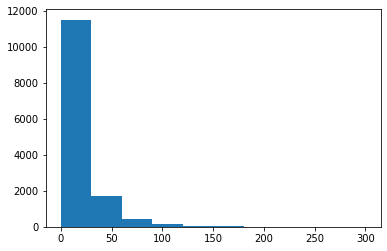

In [448]:
plt.hist(neuro['PubsOfMentorInTraning'])

In [449]:
neuro.shape

(13837, 31)

In [452]:
neuro.head(3)

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,NumOfMenteesOfTheMentor,NumOfMenteesOfTheMentor10,...,YearOfTheFirstPubsOfMenteePubs,First5YearPubsOfMentee,First5YearCitationOfMentee,First5YearCollaOfMentee,YearlyPubsOfMentee,YearlyCitationOfMentee,BirthYearOfMentee,CareerAgeOfMentorInTraining,PubsOfMentorInTraning,CollaPubsOfWithMentor
0,6,18761,9,1,"University of California, Berkeley",95457486.0,-1,1984,8,4,...,1986.0,19,745,25,7.666667,441.083333,1984.0,21.0,3,0
1,248,211,34756,1,University of Rome,NaN,-1,1928,34,6,...,1930.0,7,329,8,1.465116,38.383721,1928.0,7.0,12,0
2,273,4361,1216,1,Leiden University,121797337.0,-1,1968,24,14,...,-1.0,0,0,0,0.000000,0.000000,1968.0,-1.0,0,0


In [451]:
neuro.to_csv('physics_0123.csv',header=neuro.columns,index=0)

In [296]:
#测试大小团队中的生存率 (test survival rate)
all_big = neuro['MenteeID'][neuro.BigOrSmall==1]
all_small = neuro['MenteeID'][neuro.BigOrSmall==0]
sb = neuro['MenteeID'][neuro.Survival0==1]
sur_big = all_big[all_big.isin(sb)]
sur_small = all_small[all_small.isin(sb)]
print(len(sur_big)/len(all_big))
print(len(sur_small)/len(all_small))

0.4159897392047884
0.6671398154719659


In [297]:
neuro.head(1)

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,NumOfMenteesOfTheMentor,NumOfMenteesOfTheMentor10,...,YearOfTheFirstPubsOfMenteePubs,First5YearPubsOfMentee,First5YearCitationOfMentee,First5YearCollaOfMentee,YearlyPubsOfMentee,YearlyCitationOfMentee,BirthYearOfMentee,CareerAgeOfMentorInTraining,PubsOfMentorInTraning,CollaPubsOfWithMentor
0,6,18761,9,1,"University of California, Berkeley",95457486.0,-1,1984,8,4,...,1986.0,19,745,25,7.666667,441.083333,1984.0,21.0,3,0


In [299]:
# neuro = neuro.drop(['Unnamed: 0'],axis=1)

In [300]:
neuro.shape

(9399, 32)

In [301]:
#save data
# neuro.to_csv('physics_0123.csv',index=0)